In [1]:
import pickle
import itertools
from random import shuffle


import nltk
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.probability import FreqDist, ConditionalFreqDist

import sklearn
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.metrics import accuracy_score


In [2]:
import pandas as pd 
data = pd.read_csv("Process_train.csv")
data.head()

,Text_review,Sentiment
0,bromwell high cartoon comedy same time program...,positive
1,george carlin state issue year never plan help...,positive
2,brilliant overacting lesley warren good dramat...,positive
3,easily underrate film brook cannon sure flawed...,positive
4,typical brook film less slapstick movie actual...,positive


In [3]:
data.tail()

,Text_review,Sentiment
24979,movie feel technical feel like classroom watch...,negative
24980,kind movie enemy content watch time bloody tru...,negative
24981,descent last night stockholm film festival hug...,negative
24982,film pick pound turn rather good century film ...,negative
24983,dumb film ever nearly ever type thriller manag...,negative


In [4]:
data.columns

Index(['Text_review', 'Sentiment '], dtype='object')

In [5]:
m = data[data['Sentiment ']=='positive'] 
n = data[data['Sentiment ']=='negative'] 

In [6]:
import numpy as np
Pos_reviews = np.array(m.Text_review)
Neg_reviews = np.array(n.Text_review)

In [7]:

def bag_of_words(words):
    return dict([(word, True) for word in words])

def bigrams(words, score_fn=BigramAssocMeasures.chi_sq, n=200):
    bigram_finder = BigramCollocationFinder.from_words(words)
    bigrams = bigram_finder.nbest(score_fn, n)
    return bag_of_words(bigrams)

In [8]:
def change_s2a(x):
    x = str(x)
    array = np.array(x.split(' '))
    return array
posdata = pd.Series(Pos_reviews)
negdata = pd.Series(Neg_reviews)

posdata = posdata.apply(change_s2a)
negdata = negdata.apply(change_s2a)

In [9]:
posdata = posdata.apply(bigrams)
negdata = negdata.apply(bigrams)

In [10]:
posdata

0        {('adult', 'think'): True, ('burn', 'down'): T...
1        {('bathroom', 'picture'): True, ('blaze', 'sad...
2        {('accuse', 'turncoat'): True, ('anything', 'b...
3        {('cannon', 'sure'): True, ('cast', 'someone')...
4        {('actress', 'moment'): True, ('actually', 'pl...
                               ...                        
12484    {('average', 'pretty'): True, ('beginning', 'b...
12485    {('anyone', 'pick'): True, ('brook', 'leslie')...
12486    {('attempt', 'thriller'): True, ('average', 's...
12487    {('action', 'myself'): True, ('always', 'famil...
12488    {('adaptation', 'barker'): True, ('angle', 'ju...
Length: 12489, dtype: object

In [11]:
def create_word_scores():    
    posWords = list(itertools.chain(*posdata))
    negWords = list(itertools.chain(*negdata))

    word_fd = FreqDist()
    cond_word_fd = ConditionalFreqDist()
    for word in posWords:
        word_fd.update(word)
        cond_word_fd['pos'][word]+=1
    for word in negWords:
        word_fd.update(word)
        cond_word_fd['neg'][word]+=1

    pos_word_count = cond_word_fd['pos'].N()
    neg_word_count = cond_word_fd['neg'].N()
    total_word_count = pos_word_count + neg_word_count

    word_scores = {}
    for word, freq in word_fd.items():
        pos_score = BigramAssocMeasures.chi_sq(cond_word_fd['pos'][word], (freq, pos_word_count), total_word_count)
        neg_score = BigramAssocMeasures.chi_sq(cond_word_fd['neg'][word], (freq, neg_word_count), total_word_count)
        word_scores[word] = pos_score + neg_score

    return word_scores

In [12]:
word_scores = create_word_scores()

In [13]:
word_scores

{'adult': 3225.832564933944,
 'think': 42385.374958236236,
 'burn': 1995.8295126270464,
 'down': 13108.087817649986,
 'cartoon': 2664.8362170507153,
 'comedy': 12975.262516457879,
 'classic': 7435.733604236608,
 'line': 12087.947538803546,
 'close': 5870.397338761024,
 'reality': 3724.835415825377,
 'same': 14763.01836686593,
 'expect': 9307.528820765703,
 'many': 23953.489628353032,
 'fetch': 236.12469916282217,
 'pity': 850.5646184876813,
 'financially': 102.0508713383617,
 'insightful': 246.13052732113894,
 'immediately': 1681.4246142252741,
 'recall': 1056.7496022508242,
 'inspector': 510.30039744824717,
 'sack': 176.09065953406454,
 'lead': 10740.536577986488,
 'believe': 11138.643357517929,
 'pettiness': 8.003823536315762,
 'whole': 11243.208241785422,
 'pomp': 32.01546405505032,
 'profession': 272.145887643014,
 'repeatedly': 444.2550380535124,
 'right': 12371.609141906974,
 'pathetic': 1781.5488226228167,
 'time': 53938.841046258996,
 'satire': 986.6846361882826,
 'scramble': 7

In [14]:
def find_best_words(word_scores, number=1000):
    best_vals = sorted(word_scores.items(), key=lambda s: s[1], reverse=True)[:number]
    best_words = set([w for w, s in best_vals])
    return best_words
best_words = find_best_words(word_scores)

In [15]:
len(best_words)

1000

In [16]:
# Use chi_sq to find most informative bigrams of the review
def best_word_features(words):
    return dict([(word, True) for word in words if word in best_words])

---


In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS

Positive words


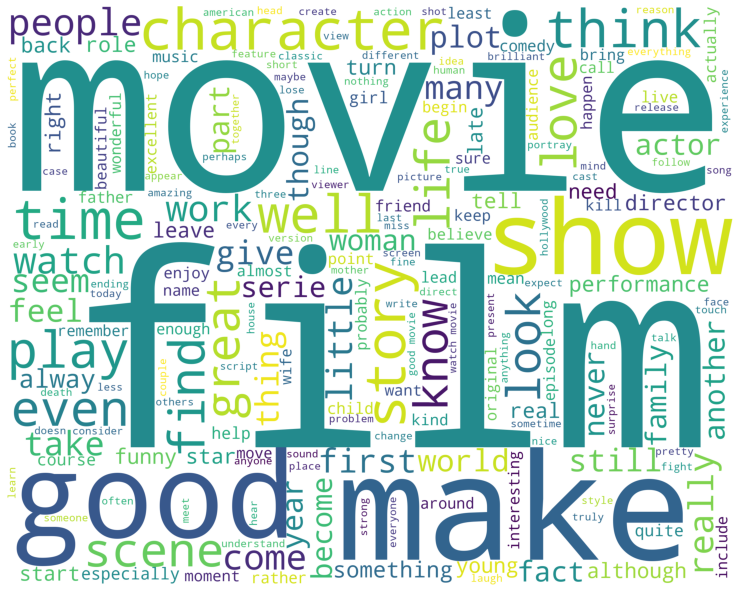

Negative words


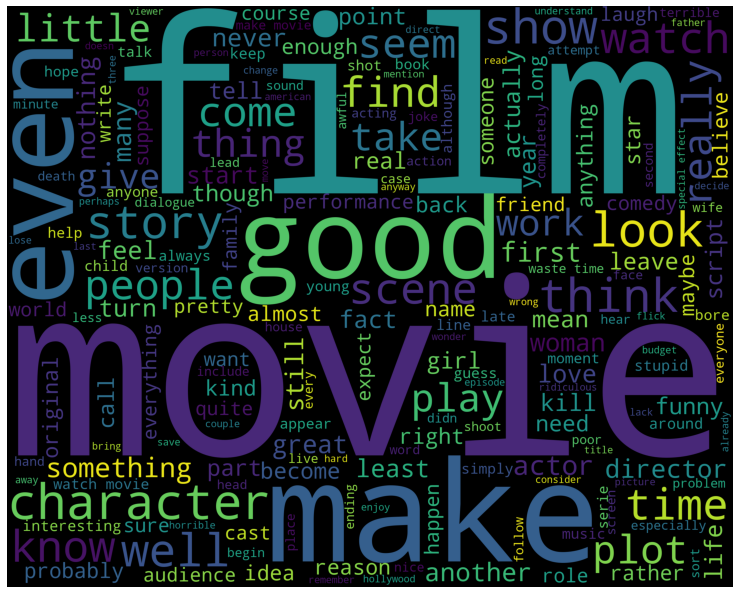

In [19]:
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(Pos_reviews,'white')
print("Negative words")
wordcloud_draw(Neg_reviews)